In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import splitfolders
import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## divide the dataset into the split,train and validation

In [ ]:
splitfolders.ratio("Potato Leaf disease Dataset in Uncontrolled Environment", output = "splited_potato_dataset", seed=1337, ratio=(.6, .2, .2))
#the split folders does the file extraction ratio indicates the split,train, and test and in what percentages .80(80%) etc and the seeds makes the splits reproducable.

In [ ]:
#this is where the data augementation is done
train_datagener = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,#more like a strech on the images on one scale
    zoom_range = 0.2,#this is the zooming of the images 
    horizontal_flip=True, #this is the horizontal flip of the images
    rotation_range=40, ##rotation of the images
    width_shift_range=0.2, #randomly shifting the images on the width axis
    height_shift_range=0.2, #randomly shifting the images on the height axis
    brightness_range=[0.2,0.8], #this is the brightness of the images
    fill_mode='nearest' # this fills the empty pixels with the nearest pixel value
    )
    #
val_datagen = ImageDataGenerator(
    rescale=1./255
    )

train_ds = train_datagener.flow_from_directory(
    directory = "splited_potato_dataset/train",
    target_size=(255,255),
    batch_size=32,
    class_mode='categorical',
)

val_ds = val_datagen.flow_from_directory(
    directory = "splited_potato_dataset/val",
    target_size=(255,255),
    batch_size=32,
    class_mode='categorical'
)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3, 3), activation='relu' ,input_shape=(256,256,3)))#moving from 16,32,64 to 8,16,32
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

#keep at this rate if the model does not improve above the range of 0.68 for the vlaidation accuracy
model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))



model.add(layers.Conv2D(64,(3,3), activation ='relu'))#block out this layer if this is not working with the dense layer 64
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(128,(3, 3), activation='relu'))#moving from 16,32,64 to 8,16,32
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))


#keep at this rate if the model does not improve above the range of 0.68 for the vlaidation accuracy
model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128,(3,3), activation ='relu'))#block out this layer if this is not working with the dense layer 64
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.summary()
#flatten the output
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))#activate this layer if the the val_accuracy is lower than 84%
#model.add(layers.Dense(64, activation='relu')) #try using this to reduce the over fitting
#model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7,activation='softmax'))#7 classes to be predicted
model.summary()

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import CategoricalCrossentropy

#compile the model
model.compile(optimizer='Adam',
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

#add a early stopping
#early_stopping = EarlyStopping(monitor='val_loss',patience=6)

#history = model.fit(train_ds, epochs=60, validation_data=val_ds,callbacks=[early_stopping])
#history = model.fit(train_ds, epochs=50, validation_data=val_ds)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
history = model.fit(train_ds, epochs=90, validation_data=val_ds,batch_size=25,callbacks=[lr_schedule])


Model loaded successfully
Found 622 images belonging to 7 classes.


c:\Users\sache\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8065 - loss: 0.5916
Test Loss: 0.7442877888679504
Test Accuracy: 0.7733119130134583
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
              precision    recall  f1-score   support

    Bacteria       0.90      0.90      0.90       115
       Fungi       0.79      0.74      0.76       151
     Healthy       0.60      0.78      0.68        41
    Nematode       0.83      0.67      0.74        15
        Pest       0.67      0.69      0.68       123
 Phytopthora       0.76      0.74      0.75        70
       Virus       0.82      0.81      0.82       107

    accuracy                           0.77       622
   macro avg       0.77      0.76      0.76       622
weighted avg       0.78      0.77      0.77       622



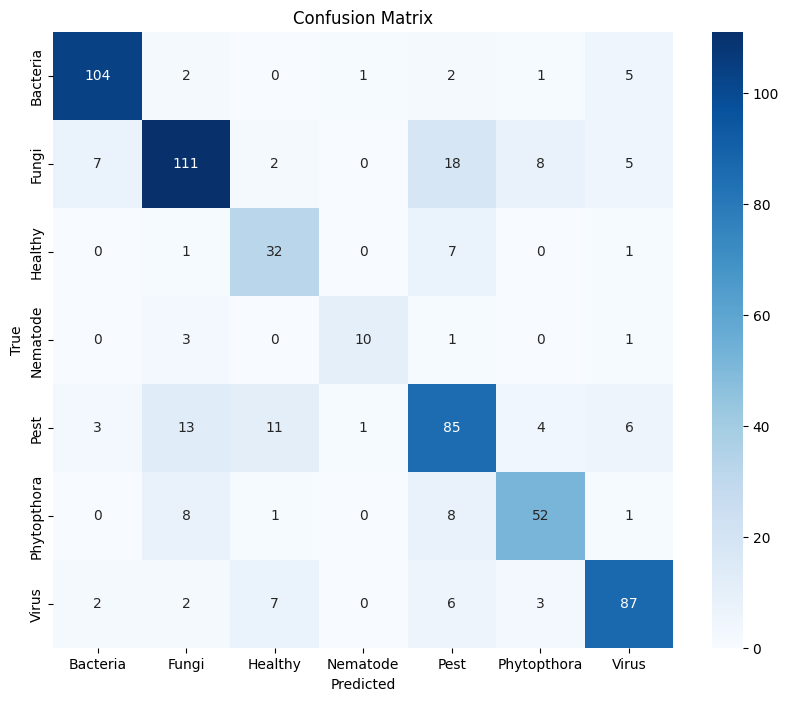

In [6]:
#define the class lables for the potato leaf disease dataset
class_labels = ['Bacteria','Fungi','healthy','Nematode','pest','pytopthra','virus']

#load the model
model_path = "potato_disease_model val accuracy 0.9050(255).keras"
model = load_model(model_path)
print("Model loaded successfully")

#define the test data directory
test_data_dir = "splited_potato_dataset/test"

#pre-process the test data through the image data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(255, 255),
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
